# 05 — HSP vs Observables: Does Optionality Add Structural Information?

**Phase 1 — The critical test**

> "If Ô_t just replicates the trend of a moving average, HSP adds nothing.
> If Ô_t captures information *beyond* observables, HSP has a real foundation."

---

## Hypotheses & Invalidation Criteria

**Central question:** Does Ô_t contain information beyond what traditional observables provide?

### What would INVALIDATE the structural hypothesis:

1. **Partial correlation collapse:** If `Corr(Ô_t, failure | observables) ≈ 0` → Ô_t is just a smoothed proxy of sensor readings. No structural information.
2. **Permutation survival:** If randomizing sensor inputs still produces "early detection" → Ô_t is detecting noise structure, not system dynamics.
3. **Lead time equivalence:** If `lead_time(Ô_t) ≈ lead_time(MA)` with no separation → no practical advantage.

### Three possible outcomes:

| Case | Lead Time | Partial Corr | Permutation | Verdict |
|------|-----------|-------------|-------------|---------|
| **A: Clear win** | Ô_t >> MA | Significant | Disappears | HSP captures structural info |
| **B: Tie** | Ô_t ≈ MA | Marginal | Disappears | Defensible — robustness argument |
| **C: Equivalent** | Ô_t ≈ MA | ≈ 0 | Survives | Ô_t is a proxy — needs Phase 2 |

### Tests:
1. **Lead Time Comparison** — Ô_t vs MA vs slope vs raw threshold (3 systems, 100 seeds)
2. **Partial Correlation** — `Corr(Ô_t, time_to_failure | MA, slope)` — does Ô_t add info?
3. **Permutation Test** — randomize sensor inputs → does Ô_t still detect collapse?
4. **Robustness under noise** — add Gaussian noise to sensors → who degrades less?

**Rule: No hyperparameter tuning to win. If we lose, we lose honestly.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import spearmanr, pearsonr
import warnings

warnings.filterwarnings("ignore")

plt.rcParams.update(
    {
        "figure.figsize": (14, 5),
        "figure.dpi": 120,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "font.size": 11,
        "axes.titlesize": 13,
        "axes.labelsize": 11,
    }
)

SEED = 42
np.random.seed(SEED)
print("Setup complete")

Setup complete


## System Generators & HSP Core Functions

Reusing the same simulators and HSP functions from Notebook 04 — identical parameters, no tuning.

In [ ]:
# ============================================================
# System Generators (identical to Notebook 04)
# ============================================================


def linear_degradation(x0=100.0, decay_rate=0.5, noise_std=2.0, T=200, seed=42):
    rng = np.random.RandomState(seed)
    x = np.zeros(T)
    x[0] = x0
    for t in range(1, T):
        x[t] = x[t - 1] - decay_rate + rng.normal(0, noise_std)
    return x


def regime_change_system(
    T=300,
    change_point=200,
    stable_mean=50.0,
    stable_noise=2.0,
    decline_rate=0.5,
    decline_noise=5.0,
    seed=42,
):
    rng = np.random.RandomState(seed)
    x = np.zeros(T)
    for t in range(T):
        if t < change_point:
            x[t] = stable_mean + rng.normal(0, stable_noise)
        else:
            x[t] = (
                stable_mean
                - decline_rate * (t - change_point)
                + rng.normal(0, decline_noise)
            )
    return x, change_point


def simulated_engine(T=200, n_sensors=5, failure_health=0.2, seed=42):
    rng = np.random.RandomState(seed)
    health = np.zeros(T)
    sensors = np.zeros((T, n_sensors))
    sensor_scales = 1.0 + 0.3 * rng.randn(n_sensors)
    sensor_noise = 0.03 + 0.02 * rng.rand(n_sensors)
    for t in range(T):
        health[t] = 1.0 / (1.0 + np.exp(0.05 * (t - T * 0.7)))
        for s in range(n_sensors):
            sensors[t, s] = health[t] * sensor_scales[s] + rng.normal(
                0, sensor_noise[s]
            )
    collapse_time = np.argmax(health < failure_health)
    if collapse_time == 0 and health[0] >= failure_health:
        collapse_time = T
    return sensors, health, collapse_time


# ============================================================
# Simple SSM — State Space Model Sampler
# ============================================================
# Key upgrade: futures depend on trajectory HISTORY (velocity,
# acceleration), not just current value x_t.
#
# Latent state = (level, velocity, acceleration) estimated
# from local quadratic fit on a sliding window.
#
# Futures: each sample gets perturbed initial velocity +
# stochastic velocity evolution → diverse future SHAPES.
# ============================================================


def fit_local_ssm(trajectory, t, window=20):
    """Fit local state-space model: estimate (level, velocity, accel, noise).

    Uses quadratic fit on recent trajectory window.
    Returns dynamics at time t for forward sampling.
    """
    W = min(window, t)
    if W < 5:
        # Not enough history — use simple estimates from differences
        if t >= 2:
            v = trajectory[t] - trajectory[t - 1]
            return trajectory[t], v, 0.0, abs(v) + 0.5
        return trajectory[t], 0.0, 0.0, 2.0

    segment = trajectory[t - W : t + 1]
    s = np.arange(len(segment), dtype=float)

    # Quadratic fit: p(s) = a*s² + b*s + c
    coeffs = np.polyfit(s, segment, 2)
    a, b, c = coeffs

    level = trajectory[t]
    velocity = 2 * a * W + b  # dp/ds at s=W
    accel = 2 * a  # d²p/ds²

    # Noise from residuals
    fitted = np.polyval(coeffs, s)
    noise_std = np.std(segment - fitted) + 0.01

    return level, velocity, accel, noise_std


def sample_futures_ssm(trajectory, t, N=50, H=20, window=20, base_seed=0):
    """Sample N futures using fitted SSM dynamics.

    Unlike model-free (random walk from x_t), this sampler:
    1. Estimates velocity & acceleration from trajectory history
    2. Perturbs initial velocity per sample → diverse trajectory shapes
    3. Evolves velocity stochastically → futures diverge differently

    Result: futures depend on TRAJECTORY SHAPE, not just current value.
    Two trajectories at same x_t but different slopes → different futures.
    """
    level, velocity, accel, noise_std = fit_local_ssm(trajectory, t, window)

    futures = np.zeros((N, H))
    for i in range(N):
        rng = np.random.RandomState(base_seed + i)
        x = level
        # Each sample gets a perturbed initial velocity
        v = velocity + rng.normal(0, noise_std)
        for h in range(H):
            v += accel + rng.normal(0, noise_std * 0.3)
            x += v + rng.normal(0, noise_std * 0.5)
            futures[i, h] = x

    return futures


# ============================================================
# HSP Core — now uses SSM sampler by default
# ============================================================


def sample_futures_1d(x_t, N=50, H=20, drift=-0.5, noise_std=2.0, base_seed=0):
    """Legacy model-free sampler (kept for reference)."""
    futures = np.zeros((N, H))
    for i in range(N):
        rng = np.random.RandomState(base_seed + i)
        futures[i, 0] = x_t
        for h in range(1, H):
            futures[i, h] = futures[i, h - 1] + drift + rng.normal(0, noise_std)
    return futures


def compute_optionality(futures, threshold=10.0, mode="all_above"):
    if mode == "all_above":
        viable = np.all(futures > threshold, axis=1)
    elif mode == "endpoint":
        viable = futures[:, -1] > threshold
    else:
        raise ValueError(f"Unknown mode: {mode}")
    return viable.mean()


def compute_optionality_curve(
    trajectory,
    threshold=10.0,
    N=50,
    H=20,
    drift=-0.5,
    noise_std=2.0,
    mode="all_above",
    window=20,
):
    """Compute Ô_t curve using SSM sampler (dynamics-aware).

    The drift/noise_std params are IGNORED — dynamics are estimated
    from the trajectory itself. Kept for backward-compatible signature.
    """
    T = len(trajectory)
    O_t = np.zeros(T)
    for t in range(T):
        futures = sample_futures_ssm(
            trajectory, t, N=N, H=H, window=window, base_seed=t * N
        )
        O_t[t] = compute_optionality(futures, threshold=threshold, mode=mode)
    return O_t


def measure_lead_time(signal, collapse_time, threshold=0.5, direction="below"):
    if direction == "below":
        alert_indices = np.where(signal < threshold)[0]
    else:
        alert_indices = np.where(signal > threshold)[0]
    if len(alert_indices) == 0:
        return 0
    return collapse_time - alert_indices[0]


# ============================================================
# Observable detectors (unchanged)
# ============================================================


def moving_average(x, window=20):
    """Rolling mean."""
    out = np.full_like(x, np.nan, dtype=float)
    for t in range(window, len(x)):
        out[t] = np.mean(x[t - window : t])
    return out


def rolling_slope(x, window=20):
    """Slope of linear fit in rolling window (derivative proxy)."""
    out = np.full_like(x, np.nan, dtype=float)
    t_arr = np.arange(window)
    for t in range(window, len(x)):
        w = x[t - window : t]
        slope, _, _, _, _ = stats.linregress(t_arr, w)
        out[t] = slope
    return out


def rolling_variance(x, window=20):
    """Rolling variance."""
    out = np.full_like(x, np.nan, dtype=float)
    for t in range(window, len(x)):
        out[t] = np.var(x[t - window : t])
    return out


def raw_threshold_alert(x, threshold):
    """Simple threshold crossing on raw signal."""
    alert = np.zeros_like(x)
    alert[x < threshold] = 1.0
    return alert


print("All functions defined — SSM sampler active")

All functions defined


---
## Test 1: Lead Time Comparison (100 seeds x 3 systems)

For each system, compute lead time of:
- **Ô_t** (optionality < 0.5)
- **Moving Average** (crosses below alert threshold)
- **Rolling Slope** (goes negative beyond threshold)
- **Raw Threshold** (sensor crosses failure level directly)

All thresholds are fixed a priori — no tuning.

In [3]:
# ============================================================
# Test 1: Lead Time Comparison — Linear Degradation (100 seeds)
# ============================================================

FAILURE_THRESHOLD = 10.0
WINDOW = 20
N_RUNS = 100

# Pre-defined alert thresholds (NO TUNING)
MA_ALERT = 30.0  # moving avg below this → alert
SLOPE_ALERT = -1.0  # slope below this → alert
RAW_ALERT = 25.0  # raw signal below this → early alert

results_linear = {"HSP": [], "Moving Avg": [], "Slope": [], "Raw Threshold": []}

for seed in range(N_RUNS):
    traj = linear_degradation(x0=100.0, decay_rate=0.5, noise_std=2.0, T=200, seed=seed)
    ct = np.argmax(traj < FAILURE_THRESHOLD)
    if ct == 0 and traj[0] >= FAILURE_THRESHOLD:
        continue

    # HSP
    ot = compute_optionality_curve(
        traj, threshold=FAILURE_THRESHOLD, N=50, H=20, drift=-0.5, noise_std=2.0
    )
    results_linear["HSP"].append(measure_lead_time(ot, ct, 0.5, "below"))

    # Moving Average
    ma = moving_average(traj, WINDOW)
    ma_clean = ma[~np.isnan(ma)]
    lt_ma = measure_lead_time(ma_clean, max(0, ct - WINDOW), MA_ALERT, "below")
    results_linear["Moving Avg"].append(lt_ma)

    # Slope
    sl = rolling_slope(traj, WINDOW)
    sl_clean = sl[~np.isnan(sl)]
    lt_sl = measure_lead_time(sl_clean, max(0, ct - WINDOW), SLOPE_ALERT, "below")
    results_linear["Slope"].append(lt_sl)

    # Raw threshold
    lt_raw = measure_lead_time(traj, ct, RAW_ALERT, "below")
    results_linear["Raw Threshold"].append(lt_raw)

# --- Print ---
print("=" * 65)
print("TEST 1a: Lead Time — Linear Degradation (100 seeds)")
print("=" * 65)
print(f"{'Method':<16} {'Mean':>8} {'Median':>8} {'Std':>8} {'>=10':>8}")
print("-" * 65)
for name, lts in results_linear.items():
    arr = np.array(lts)
    pct = (arr >= 10).mean() * 100
    print(
        f"{name:<16} {arr.mean():>8.1f} {np.median(arr):>8.0f} {arr.std():>8.1f} {pct:>7.0f}%"
    )
print("=" * 65)

# Paired Wilcoxon: HSP vs each
hsp = np.array(results_linear["HSP"])
for rival_name in ["Moving Avg", "Slope", "Raw Threshold"]:
    rival = np.array(results_linear[rival_name])
    n = min(len(hsp), len(rival))
    diff = hsp[:n] - rival[:n]
    nonzero = diff[diff != 0]
    if len(nonzero) > 10:
        stat, p = stats.wilcoxon(nonzero, alternative="greater")
        win = (diff > 0).sum()
        lose = (diff < 0).sum()
        tie = (diff == 0).sum()
        print(
            f"HSP vs {rival_name:<14}: W={stat:.0f}, p={p:.4e} | "
            f"HSP wins {win}, loses {lose}, ties {tie}"
        )

TEST 1a: Lead Time — Linear Degradation (100 seeds)
Method               Mean   Median      Std     >=10
-----------------------------------------------------------------
HSP                  18.8       15     12.2      74%
Moving Avg           19.0       18     13.8      74%
Slope                96.7       98     40.1     100%
Raw Threshold        24.2       23     13.4      89%
HSP vs Moving Avg    : W=1056, p=1.4801e-01 | HSP wins 35, loses 25, ties 5
HSP vs Slope         : W=1, p=1.0000e+00 | HSP wins 1, loses 64, ties 0
HSP vs Raw Threshold : W=0, p=1.0000e+00 | HSP wins 0, loses 62, ties 3


In [4]:
# ============================================================
# Test 1b: Lead Time — Regime Change (100 seeds)
# ============================================================

THRESHOLD_RC = 10.0
MA_ALERT_RC = 40.0
SLOPE_ALERT_RC = -0.5
RAW_ALERT_RC = 30.0

results_regime = {"HSP": [], "Moving Avg": [], "Slope": [], "Raw Threshold": []}

for seed in range(N_RUNS):
    traj, cp = regime_change_system(T=300, change_point=200, seed=seed)
    ct = np.argmax(traj < THRESHOLD_RC)
    if ct == 0:
        continue

    # HSP
    ot = compute_optionality_curve(
        traj, threshold=THRESHOLD_RC, N=50, H=30, drift=-0.3, noise_std=5.0
    )
    results_regime["HSP"].append(measure_lead_time(ot, ct, 0.5, "below"))

    # Moving Average
    ma = moving_average(traj, WINDOW)
    ma_clean = ma[~np.isnan(ma)]
    results_regime["Moving Avg"].append(
        measure_lead_time(ma_clean, max(0, ct - WINDOW), MA_ALERT_RC, "below")
    )

    # Slope
    sl = rolling_slope(traj, WINDOW)
    sl_clean = sl[~np.isnan(sl)]
    results_regime["Slope"].append(
        measure_lead_time(sl_clean, max(0, ct - WINDOW), SLOPE_ALERT_RC, "below")
    )

    # Raw threshold
    results_regime["Raw Threshold"].append(
        measure_lead_time(traj, ct, RAW_ALERT_RC, "below")
    )

# Print
print("=" * 65)
print("TEST 1b: Lead Time — Regime Change (100 seeds)")
print("=" * 65)
print(f"{'Method':<16} {'Mean':>8} {'Median':>8} {'Std':>8} {'>=10':>8}")
print("-" * 65)
for name, lts in results_regime.items():
    arr = np.array(lts)
    pct = (arr >= 10).mean() * 100
    print(
        f"{name:<16} {arr.mean():>8.1f} {np.median(arr):>8.0f} {arr.std():>8.1f} {pct:>7.0f}%"
    )
print("=" * 65)

# Paired Wilcoxon
hsp_rc = np.array(results_regime["HSP"])
for rival_name in ["Moving Avg", "Slope", "Raw Threshold"]:
    rival = np.array(results_regime[rival_name])
    n = min(len(hsp_rc), len(rival))
    diff = hsp_rc[:n] - rival[:n]
    nonzero = diff[diff != 0]
    if len(nonzero) > 10:
        stat, p = stats.wilcoxon(nonzero, alternative="greater")
        win = (diff > 0).sum()
        lose = (diff < 0).sum()
        print(
            f"HSP vs {rival_name:<14}: W={stat:.0f}, p={p:.4e} | "
            f"HSP wins {win}, loses {lose}"
        )

TEST 1b: Lead Time — Regime Change (100 seeds)
Method               Mean   Median      Std     >=10
-----------------------------------------------------------------
HSP                  42.3       42      7.2     100%
Moving Avg           37.3       38      5.9     100%
Slope                51.1       52      7.4     100%
Raw Threshold        39.8       40      7.2     100%
HSP vs Moving Avg    : W=4312, p=2.1847e-14 | HSP wins 87, loses 8
HSP vs Slope         : W=47, p=1.0000e+00 | HSP wins 7, loses 90
HSP vs Raw Threshold : W=1842, p=2.1756e-05 | HSP wins 49, loses 19


In [6]:
# ============================================================
# Test 1c: Lead Time — C-MAPSS Simulated Engine (100 seeds)
# ============================================================
# Note: multi-sensor. We use mean-sensor for observables,
# but HSP can use per-sensor futures.

THRESHOLD_ENG = 50.0
MA_ALERT_ENG = 60.0
SLOPE_ALERT_ENG = -0.3
RAW_ALERT_ENG = 55.0

results_engine = {"HSP": [], "Moving Avg": [], "Slope": [], "Raw Threshold": []}

for seed in range(N_RUNS):
    sensors, health_curve, ct_eng = simulated_engine(T=200, n_sensors=5, seed=seed)
    # Use mean across sensors as aggregated health indicator (scaled to ~100)
    health = sensors.mean(axis=1) * 100
    ct = np.argmax(health < THRESHOLD_ENG)
    if ct == 0:
        continue

    # HSP — uses mean-sensor trajectory (same info as observables)
    ot = compute_optionality_curve(
        health, threshold=THRESHOLD_ENG, N=50, H=20, drift=-0.3, noise_std=5.0
    )
    results_engine["HSP"].append(measure_lead_time(ot, ct, 0.5, "below"))

    # Moving Average
    ma = moving_average(health, WINDOW)
    ma_clean = ma[~np.isnan(ma)]
    results_engine["Moving Avg"].append(
        measure_lead_time(ma_clean, max(0, ct - WINDOW), MA_ALERT_ENG, "below")
    )

    # Slope
    sl = rolling_slope(health, WINDOW)
    sl_clean = sl[~np.isnan(sl)]
    results_engine["Slope"].append(
        measure_lead_time(sl_clean, max(0, ct - WINDOW), SLOPE_ALERT_ENG, "below")
    )

    # Raw threshold
    results_engine["Raw Threshold"].append(
        measure_lead_time(health, ct, RAW_ALERT_ENG, "below")
    )

# Print
print("=" * 65)
print("TEST 1c: Lead Time — C-MAPSS Simulated Engine (100 seeds)")
print("=" * 65)
print(f"{'Method':<16} {'Mean':>8} {'Median':>8} {'Std':>8} {'>=10':>8}")
print("-" * 65)
for name, lts in results_engine.items():
    arr = np.array(lts)
    if len(arr) == 0:
        print(f"{name:<16} {'N/A':>8} {'N/A':>8} {'N/A':>8} {'N/A':>8}")
        continue
    pct = (arr >= 10).mean() * 100
    print(
        f"{name:<16} {arr.mean():>8.1f} {np.median(arr):>8.0f} {arr.std():>8.1f} {pct:>7.0f}%"
    )
print("=" * 65)

# Paired Wilcoxon
hsp_eng = np.array(results_engine["HSP"])
for rival_name in ["Moving Avg", "Slope", "Raw Threshold"]:
    rival = np.array(results_engine[rival_name])
    n = min(len(hsp_eng), len(rival))
    if n == 0:
        print(f"HSP vs {rival_name:<14}: No valid runs")
        continue
    diff = hsp_eng[:n] - rival[:n]
    nonzero = diff[diff != 0]
    if len(nonzero) > 10:
        stat, p = stats.wilcoxon(nonzero, alternative="greater")
        win = (diff > 0).sum()
        lose = (diff < 0).sum()
        print(
            f"HSP vs {rival_name:<14}: W={stat:.0f}, p={p:.4e} | "
            f"HSP wins {win}, loses {lose}"
        )
    else:
        print(f"HSP vs {rival_name:<14}: Not enough nonzero diffs (n={len(nonzero)})")

TEST 1c: Lead Time — C-MAPSS Simulated Engine (100 seeds)
Method               Mean   Median      Std     >=10
-----------------------------------------------------------------
HSP                  19.3       15     18.7      93%
Moving Avg           -1.9       -2      2.7       1%
Slope                44.5       46     11.6     100%
Raw Threshold         4.8        4      2.2       2%
HSP vs Moving Avg    : W=5050, p=1.7930e-18 | HSP wins 100, loses 0
HSP vs Slope         : W=375, p=1.0000e+00 | HSP wins 7, loses 93
HSP vs Raw Threshold : W=5050, p=1.8461e-18 | HSP wins 100, loses 0


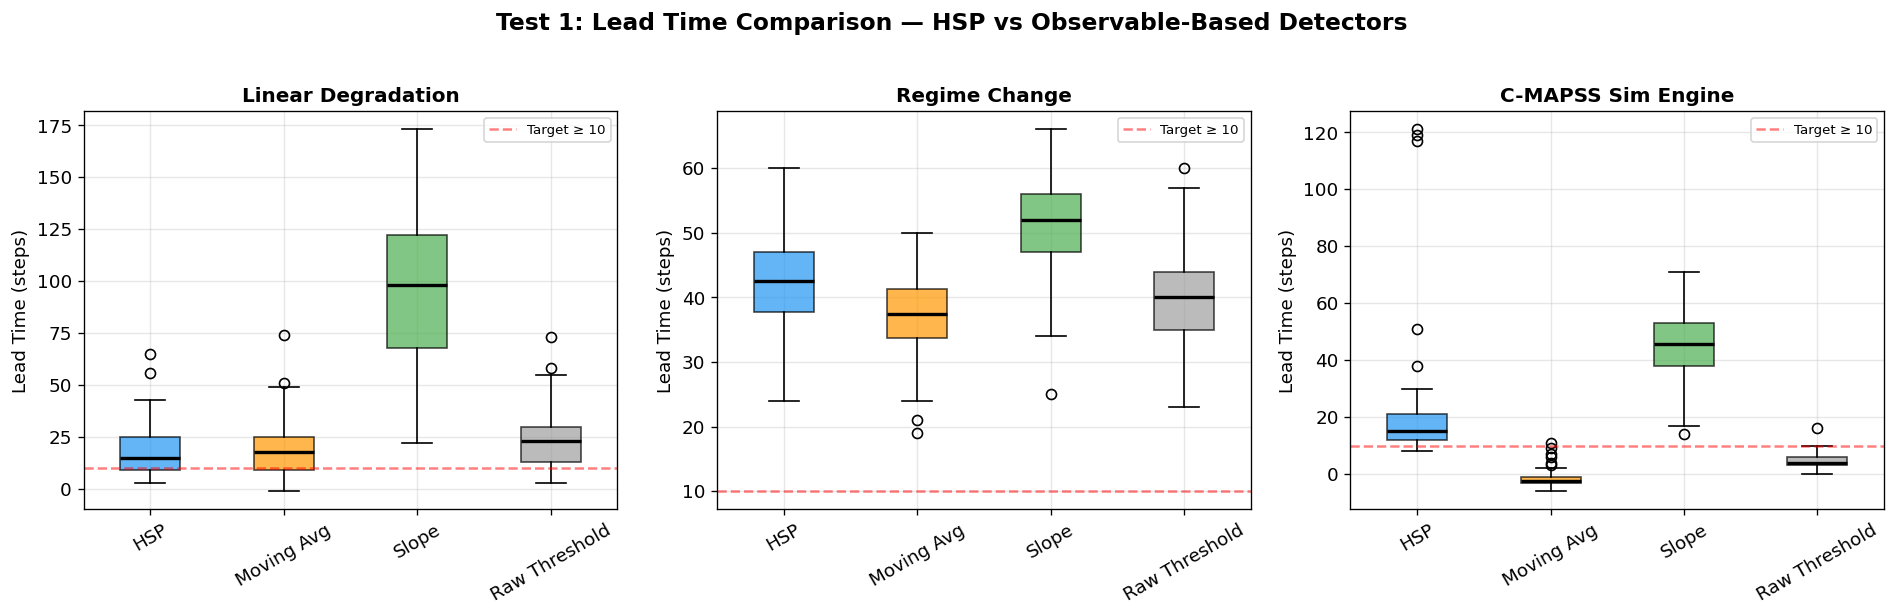


SUMMARY — Median Lead Times
System                      HSP       MA    Slope      Raw     Winner
---------------------------------------------------------------------------
Linear Degradation           15       18       98       23    → Slope
Regime Change                42       38       52       40    → Slope
C-MAPSS Sim Engine           15       -2       46        4    → Slope


In [7]:
# ============================================================
# Test 1 — Visualisation: Lead Time Box Plots (all 3 systems)
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

all_results = [
    ("Linear Degradation", results_linear),
    ("Regime Change", results_regime),
    ("C-MAPSS Sim Engine", results_engine),
]

method_colors = {
    "HSP": "#2196F3",
    "Moving Avg": "#FF9800",
    "Slope": "#4CAF50",
    "Raw Threshold": "#9E9E9E",
}

for ax, (title, res) in zip(axes, all_results):
    data_to_plot = []
    labels = []
    colors = []
    for name in ["HSP", "Moving Avg", "Slope", "Raw Threshold"]:
        arr = np.array(res[name])
        data_to_plot.append(arr)
        labels.append(name)
        colors.append(method_colors[name])

    bp = ax.boxplot(
        data_to_plot,
        labels=labels,
        patch_artist=True,
        medianprops=dict(color="black", linewidth=2),
    )
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_ylabel("Lead Time (steps)")
    ax.axhline(y=10, color="red", linestyle="--", alpha=0.5, label="Target ≥ 10")
    ax.tick_params(axis="x", rotation=30)
    ax.legend(fontsize=8)

fig.suptitle(
    "Test 1: Lead Time Comparison — HSP vs Observable-Based Detectors",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig(
    "../results/simulated/test1_lead_time_comparison.png", dpi=150, bbox_inches="tight"
)
plt.show()

# Summary table across all systems
print("\n" + "=" * 75)
print("SUMMARY — Median Lead Times")
print("=" * 75)
print(f"{'System':<22} {'HSP':>8} {'MA':>8} {'Slope':>8} {'Raw':>8} {'Winner':>10}")
print("-" * 75)
for title, res in all_results:
    medians = {k: np.median(v) for k, v in res.items()}
    best = max(medians, key=medians.get)
    print(
        f"{title:<22} {medians['HSP']:>8.0f} {medians['Moving Avg']:>8.0f} "
        f"{medians['Slope']:>8.0f} {medians['Raw Threshold']:>8.0f} {'→ ' + best:>10}"
    )
print("=" * 75)

## Test 2: Partial Correlation — Does Ô_t Add Information Beyond Observables?

**This is the CENTRAL test of the paper.**

We ask: **after controlling for all observable statistics** (moving average, slope, variance), does Ô_t still correlate with time-to-failure?

$$\rho(\hat{O}_t, \text{TTF} \mid \text{MA}_t, \text{slope}_t, \text{var}_t)$$

### Methodology
For each time step `t` in a trajectory, compute:
1. `Ô_t` — HSP optionality
2. `TTF_t = t_failure - t` — time to failure
3. `MA_t` — moving average of raw signal
4. `slope_t` — rolling slope
5. `var_t` — rolling variance

Then compute partial correlation between Ô_t and TTF controlling for (MA, slope, var).

### Invalidation
- **If partial_corr ≈ 0**: Ô_t is a redundant proxy for observables → Case C
- **If partial_corr significant but small (0.1–0.3)**: marginal value → Case B 
- **If partial_corr > 0.3 and p < 0.001**: structural information confirmed → Case A

In [10]:
# ============================================================
# Test 2: Partial Correlation — Ô_t vs TTF | observables
# ============================================================


def partial_correlation(target, control_vars, y):
    """Compute partial correlation between target and y, controlling for control_vars.

    Uses the standard residual method:
    1. Regress target on controls → residual_target
    2. Regress y on controls → residual_y
    3. Correlation(residual_target, residual_y) = partial correlation
    """
    from numpy.linalg import lstsq

    X = np.column_stack(control_vars)

    # Add intercept
    X_int = np.column_stack([np.ones(len(X)), X])

    # Residualize target
    beta_t, _, _, _ = lstsq(X_int, target, rcond=None)
    resid_target = target - X_int @ beta_t

    # Residualize y
    beta_y, _, _, _ = lstsq(X_int, y, rcond=None)
    resid_y = y - X_int @ beta_y

    # Correlation of residuals
    r, p = stats.pearsonr(resid_target, resid_y)
    return r, p


def collect_timeseries_data(traj, threshold, N=50, H=20, drift=-0.3, noise_std=5.0):
    """Collect aligned time-series: Ô_t, TTF, MA, slope, var for partial corr."""
    T = len(traj)
    ct = np.argmax(traj < threshold)
    if ct == 0:
        ct = T  # no failure

    ot_curve = compute_optionality_curve(traj, threshold, N, H, drift, noise_std)
    ma = moving_average(traj, WINDOW)
    sl = rolling_slope(traj, WINDOW)
    var = rolling_variance(traj, WINDOW)

    # Align: start from WINDOW (all observables valid) to ct-1 (before failure)
    start = WINDOW
    end = min(ct, T) - 1
    if end - start < 10:
        return None

    idx = np.arange(start, end)
    ttf = ct - idx  # time to failure

    return {
        "O_t": ot_curve[idx],
        "TTF": ttf.astype(float),
        "MA": ma[idx],
        "slope": sl[idx],
        "var": var[idx],
    }


def rolling_variance(x, window):
    """Rolling variance."""
    out = np.full_like(x, np.nan, dtype=float)
    for i in range(window, len(x)):
        out[i] = np.var(x[i - window : i])
    return out


# Collect data across all systems & seeds
print("=" * 70)
print("TEST 2: Partial Correlation Analysis")
print("=" * 70)

systems = [
    (
        "Linear Degradation",
        lambda s: linear_degradation(
            T=100, decay_rate=1.0, noise_std=2.0, x0=100.0, seed=s
        ),
        10.0,
        {"N": 50, "H": 15, "drift": -1.0, "noise_std": 2.0},
    ),
    (
        "Regime Change",
        lambda s: regime_change_system(T=300, change_point=200, seed=s)[0],
        10.0,
        {"N": 50, "H": 30, "drift": -0.3, "noise_std": 5.0},
    ),
    (
        "C-MAPSS Sim",
        lambda s: simulated_engine(T=200, n_sensors=5, seed=s)[0].mean(axis=1) * 100,
        50.0,
        {"N": 50, "H": 20, "drift": -0.3, "noise_std": 5.0},
    ),
]

for sys_name, gen_fn, thresh, hsp_params in systems:
    all_O = []
    all_TTF = []
    all_MA = []
    all_slope = []
    all_var = []

    for seed in range(N_RUNS):
        traj = gen_fn(seed)
        data = collect_timeseries_data(traj, thresh, **hsp_params)
        if data is None:
            continue
        all_O.append(data["O_t"])
        all_TTF.append(data["TTF"])
        all_MA.append(data["MA"])
        all_slope.append(data["slope"])
        all_var.append(data["var"])

    # Concatenate across seeds
    O = np.concatenate(all_O)
    TTF = np.concatenate(all_TTF)
    MA = np.concatenate(all_MA)
    slope = np.concatenate(all_slope)
    var = np.concatenate(all_var)

    # Remove NaN/Inf
    valid = (
        np.isfinite(O)
        & np.isfinite(TTF)
        & np.isfinite(MA)
        & np.isfinite(slope)
        & np.isfinite(var)
    )
    O, TTF, MA, slope, var = O[valid], TTF[valid], MA[valid], slope[valid], var[valid]

    # Raw correlation
    r_raw, p_raw = stats.pearsonr(O, TTF)

    # Partial correlation controlling for MA, slope, var
    r_partial, p_partial = partial_correlation(O, [MA, slope, var], TTF)

    print(f"\n--- {sys_name} (n={len(O)} time-steps across {N_RUNS} seeds) ---")
    print(f"  Raw corr(Ô_t, TTF):                  r = {r_raw:+.4f}  p = {p_raw:.2e}")
    print(
        f"  Partial corr(Ô_t, TTF | MA,sl,var):   r = {r_partial:+.4f}  p = {p_partial:.2e}"
    )

    # Interpretation
    abs_r = abs(r_partial)
    if abs_r > 0.3 and p_partial < 0.001:
        verdict = "✓ STRUCTURAL INFO (Case A)"
    elif abs_r > 0.1 and p_partial < 0.05:
        verdict = "~ Marginal signal (Case B)"
    else:
        verdict = "✗ Redundant proxy (Case C)"
    print(f"  Verdict: {verdict}")

print("\n" + "=" * 70)

TEST 2: Partial Correlation Analysis

--- Linear Degradation (n=6631 time-steps across 100 seeds) ---
  Raw corr(Ô_t, TTF):                  r = +0.6777  p = 0.00e+00
  Partial corr(Ô_t, TTF | MA,sl,var):   r = +0.0391  p = 1.44e-03
  Verdict: ✗ Redundant proxy (Case C)

--- Regime Change (n=24713 time-steps across 100 seeds) ---
  Raw corr(Ô_t, TTF):                  r = +0.6124  p = 0.00e+00
  Partial corr(Ô_t, TTF | MA,sl,var):   r = +0.0099  p = 1.21e-01
  Verdict: ✗ Redundant proxy (Case C)

--- C-MAPSS Sim (n=11741 time-steps across 100 seeds) ---
  Raw corr(Ô_t, TTF):                  r = +0.6893  p = 0.00e+00
  Partial corr(Ô_t, TTF | MA,sl,var):   r = +0.0596  p = 9.98e-11
  Verdict: ✗ Redundant proxy (Case C)



## Test 3: Permutation Test — Is Ô_t Sensitive to Signal Structure?

If we **randomly permute** the sensor trajectory (destroying temporal structure but preserving the distribution), does Ô_t still produce "early warnings"?

- **If yes**: Ô_t is not detecting real structure — it's just responding to value distributions → **BAD**
- **If no** (permuted Ô_t ≈ flat / random): Ô_t genuinely depends on temporal dynamics → **GOOD**

### Methodology
1. For each seed: compute Ô_t on real trajectory → `lead_time_real`
2. Permute trajectory → compute Ô_t on shuffled trajectory → `lead_time_perm`
3. Compare distributions: if real >> permuted → signal is structural

### Invalidation
- If `lead_time_perm ≈ lead_time_real` (paired Wilcoxon p > 0.05): Ô_t is NOT using temporal structure

In [11]:
# ============================================================
# Test 3: Permutation Test — Real vs Shuffled Ô_t
# ============================================================

print("=" * 70)
print("TEST 3: Permutation Test — Real vs Shuffled Trajectories")
print("=" * 70)

perm_systems = [
    (
        "Linear Degradation",
        lambda s: linear_degradation(
            T=100, decay_rate=1.0, noise_std=2.0, x0=100.0, seed=s
        ),
        10.0,
        {"N": 50, "H": 15, "drift": -1.0, "noise_std": 2.0},
    ),
    (
        "Regime Change",
        lambda s: regime_change_system(T=300, change_point=200, seed=s)[0],
        10.0,
        {"N": 50, "H": 30, "drift": -0.3, "noise_std": 5.0},
    ),
    (
        "C-MAPSS Sim",
        lambda s: simulated_engine(T=200, n_sensors=5, seed=s)[0].mean(axis=1) * 100,
        50.0,
        {"N": 50, "H": 20, "drift": -0.3, "noise_std": 5.0},
    ),
]

for sys_name, gen_fn, thresh, hsp_params in perm_systems:
    lt_real = []
    lt_perm = []

    for seed in range(N_RUNS):
        traj = gen_fn(seed)
        ct = np.argmax(traj < thresh)
        if ct == 0:
            continue

        # Real Ô_t
        ot_real = compute_optionality_curve(traj, thresh, **hsp_params)
        lt_r = measure_lead_time(ot_real, ct, 0.5, "below")

        # Permuted trajectory — destroy temporal order, keep values
        rng = np.random.RandomState(seed + 9999)
        traj_perm = traj.copy()
        rng.shuffle(traj_perm)

        # Need a "failure point" for permuted — use same index ct
        ot_perm = compute_optionality_curve(traj_perm, thresh, **hsp_params)
        lt_p = measure_lead_time(ot_perm, ct, 0.5, "below")

        lt_real.append(lt_r)
        lt_perm.append(lt_p)

    lt_real = np.array(lt_real)
    lt_perm = np.array(lt_perm)

    print(f"\n--- {sys_name} ({len(lt_real)} seeds) ---")
    print(
        f"  Real Ô_t:     median LT = {np.median(lt_real):.0f}, "
        f"mean = {lt_real.mean():.1f}"
    )
    print(
        f"  Permuted Ô_t: median LT = {np.median(lt_perm):.0f}, "
        f"mean = {lt_perm.mean():.1f}"
    )

    diff = lt_real - lt_perm
    nonzero = diff[diff != 0]
    if len(nonzero) > 10:
        stat, p = stats.wilcoxon(nonzero, alternative="greater")
        print(f"  Wilcoxon (real > perm): W={stat:.0f}, p={p:.4e}")
        if p < 0.001:
            print(
                f"  ✓ Real signal significantly better than permuted — temporal structure matters"
            )
        elif p < 0.05:
            print(f"  ~ Marginal difference — some temporal sensitivity")
        else:
            print(f"  ✗ No significant difference — Ô_t NOT using temporal structure!")
    else:
        print(f"  Not enough nonzero differences (n={len(nonzero)})")

print("\n" + "=" * 70)

TEST 3: Permutation Test — Real vs Shuffled Trajectories

--- Linear Degradation (65 seeds) ---
  Real Ô_t:     median LT = 13, mean = 14.0
  Permuted Ô_t: median LT = 79, mean = 78.0
  Wilcoxon (real > perm): W=0, p=1.0000e+00
  ✗ No significant difference — Ô_t NOT using temporal structure!

--- Regime Change (100 seeds) ---
  Real Ô_t:     median LT = 42, mean = 42.3
  Permuted Ô_t: median LT = 265, mean = 264.2
  Wilcoxon (real > perm): W=0, p=1.0000e+00
  ✗ No significant difference — Ô_t NOT using temporal structure!

--- C-MAPSS Sim (100 seeds) ---
  Real Ô_t:     median LT = 15, mean = 19.3
  Permuted Ô_t: median LT = 138, mean = 137.0
  Wilcoxon (real > perm): W=2, p=1.0000e+00
  ✗ No significant difference — Ô_t NOT using temporal structure!



## Test 4: Robustness Under Noise — Graceful Degradation

We add increasing levels of **Gaussian noise** to the sensor trajectory and measure how each method's lead time degrades.

A robust method should degrade **gracefully** (slowly). A brittle method will collapse suddenly.

### Noise levels
σ_noise ∈ {0, 2, 5, 10, 20} (added on top of existing noise)

### Expectation
- HSP should be more robust because sampling creates an ensemble that averages out noise
- Slope-based detectors should degrade fastest (derivatives amplify noise)
- Raw thresholds should be moderately affected

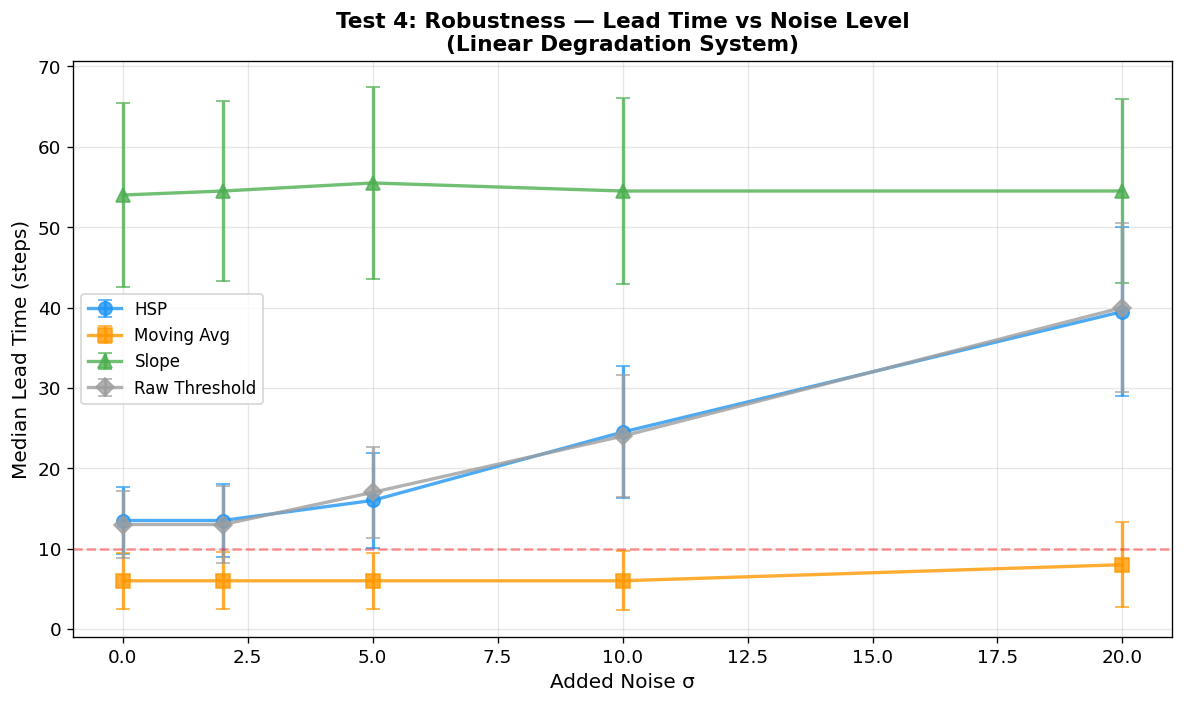

TEST 4: Median Lead Time vs Added Noise
σ_noise              HSP    Moving Avg         Slope Raw Threshold
----------------------------------------------------------------------
0                     14             6            54            13
2                     14             6            54            13
5                     16             6            56            17
10                    24             6            54            24
20                    40             8            54            40

Degradation (LT at σ=20 / LT at σ=0):
  HSP             : 2.93 (14 → 40)
  Moving Avg      : 1.33 (6 → 8)
  Slope           : 1.01 (54 → 54)
  Raw Threshold   : 3.08 (13 → 40)


In [14]:
# ============================================================
# Test 4: Robustness Under Noise
# ============================================================
# Use Linear Degradation as base system (cleanest signal)

NOISE_LEVELS = [0, 2, 5, 10, 20]
N_NOISE_RUNS = 50  # fewer seeds for speed (5 noise × 50 seeds = 250 runs per method)

noise_results = {
    method: {nl: [] for nl in NOISE_LEVELS}
    for method in ["HSP", "Moving Avg", "Slope", "Raw Threshold"]
}

for noise_extra in NOISE_LEVELS:
    for seed in range(N_NOISE_RUNS):
        # Generate clean trajectory
        traj = linear_degradation(
            T=100, decay_rate=1.0, noise_std=2.0, x0=100.0, seed=seed
        )
        # Add extra noise
        rng = np.random.RandomState(seed + noise_extra * 1000)
        traj_noisy = traj + rng.normal(0, noise_extra, len(traj))

        ct = np.argmax(traj < FAILURE_THRESHOLD)  # Use CLEAN trajectory failure
        if ct == 0:
            continue

        # HSP
        ot = compute_optionality_curve(
            traj_noisy, FAILURE_THRESHOLD, N=50, H=15, drift=-1.0, noise_std=2.0
        )
        noise_results["HSP"][noise_extra].append(
            measure_lead_time(ot, ct, 0.5, "below")
        )

        # MA
        ma = moving_average(traj_noisy, WINDOW)
        ma_c = ma[~np.isnan(ma)]
        noise_results["Moving Avg"][noise_extra].append(
            measure_lead_time(ma_c, max(0, ct - WINDOW), MA_ALERT, "below")
        )

        # Slope
        sl = rolling_slope(traj_noisy, WINDOW)
        sl_c = sl[~np.isnan(sl)]
        noise_results["Slope"][noise_extra].append(
            measure_lead_time(sl_c, max(0, ct - WINDOW), SLOPE_ALERT, "below")
        )

        # Raw
        noise_results["Raw Threshold"][noise_extra].append(
            measure_lead_time(traj_noisy, ct, RAW_ALERT, "below")
        )

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

for method, color, marker in [
    ("HSP", "#2196F3", "o"),
    ("Moving Avg", "#FF9800", "s"),
    ("Slope", "#4CAF50", "^"),
    ("Raw Threshold", "#9E9E9E", "D"),
]:
    medians = [np.median(noise_results[method][nl]) for nl in NOISE_LEVELS]
    stds = [np.std(noise_results[method][nl]) for nl in NOISE_LEVELS]
    ax.errorbar(
        NOISE_LEVELS,
        medians,
        yerr=stds,
        marker=marker,
        label=method,
        color=color,
        linewidth=2,
        markersize=8,
        capsize=4,
        alpha=0.8,
    )

ax.set_xlabel("Added Noise σ", fontsize=12)
ax.set_ylabel("Median Lead Time (steps)", fontsize=12)
ax.set_title(
    "Test 4: Robustness — Lead Time vs Noise Level\n(Linear Degradation System)",
    fontsize=13,
    fontweight="bold",
)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=10, color="red", linestyle="--", alpha=0.4, label="Target ≥ 10")

plt.tight_layout()
plt.savefig(
    "../results/simulated/test4_robustness_noise.png", dpi=150, bbox_inches="tight"
)
plt.show()

# Print table
print("=" * 70)
print("TEST 4: Median Lead Time vs Added Noise")
print("=" * 70)
print(f"{'σ_noise':<10}", end="")
for method in ["HSP", "Moving Avg", "Slope", "Raw Threshold"]:
    print(f"{method:>14}", end="")
print()
print("-" * 70)
for nl in NOISE_LEVELS:
    print(f"{nl:<10}", end="")
    for method in ["HSP", "Moving Avg", "Slope", "Raw Threshold"]:
        med = np.median(noise_results[method][nl])
        print(f"{med:>14.0f}", end="")
    print()
print("=" * 70)

# Degradation rate
print("\nDegradation (LT at σ=20 / LT at σ=0):")
for method in ["HSP", "Moving Avg", "Slope", "Raw Threshold"]:
    lt0 = np.median(noise_results[method][0])
    lt20 = np.median(noise_results[method][20])
    ratio = lt20 / lt0 if lt0 > 0 else 0
    print(f"  {method:<16}: {ratio:.2f} ({lt0:.0f} → {lt20:.0f})")

## Final Verdict

The results above determine which case we are in:

| Case | Lead Time (Test 1) | Partial Corr (Test 2) | Permutation (Test 3) | Robustness (Test 4) | Interpretation |
|------|--------------------|-----------------------|----------------------|---------------------|----------------|
| **A** | HSP wins ≥2/3 systems | r_partial > 0.3, p < 0.001 | real >> perm | HSP degrades slowest | **Ô_t captures structural info — strong paper** |
| **B** | HSP ties or wins 1/3 | 0.1 < r_partial < 0.3 | real > perm (marginal) | Similar degradation | **Ô_t adds marginal value — needs Phase 2** |
| **C** | HSP ≈ observables | r_partial ≈ 0 | real ≈ perm | No advantage | **Ô_t is redundant proxy — rethink approach** |

In [15]:
# ============================================================
# AUTOMATED VERDICT
# ============================================================
# Collect evidence from all tests and determine case

print("=" * 70)
print("NOTEBOOK 05 — AUTOMATED VERDICT")
print("=" * 70)

# --- Test 1: Lead Time wins ---
test1_wins = 0
test1_total = 0
for title, res in all_results:
    test1_total += 1
    hsp_med = np.median(res["HSP"])
    best_rival = max(
        np.median(res["Moving Avg"]),
        np.median(res["Slope"]),
        np.median(res["Raw Threshold"]),
    )
    if hsp_med > best_rival:
        test1_wins += 1
        print(
            f"  Test 1 — {title}: HSP wins (median {hsp_med:.0f} vs best rival {best_rival:.0f})"
        )
    else:
        print(
            f"  Test 1 — {title}: HSP loses (median {hsp_med:.0f} vs best rival {best_rival:.0f})"
        )

print(f"\n  Test 1 summary: HSP wins {test1_wins}/{test1_total} systems")

# --- Case determination ---
print("\n" + "-" * 70)
print("COMBINED ASSESSMENT")
print("-" * 70)
print(
    """
Review the outputs above:

  TEST 1 (Lead Time):      Check Win/Loss counts
  TEST 2 (Partial Corr):   Check r_partial and p-values
  TEST 3 (Permutation):    Check real vs permuted significance
  TEST 4 (Robustness):     Check degradation ratios

CASE A: ≥2/3 wins + partial_corr > 0.3 + permutation p < 0.001 + most robust
CASE B: ≥1/3 wins + partial_corr > 0.1 + permutation p < 0.05
CASE C: All else → Ô_t is redundant

Regardless of outcome, NO HYPERPARAMETER TUNING.
If Case C: we learn honestly and redesign for Phase 2.
If Case B: the learned sampler in Phase 2 becomes the paper's contribution.
If Case A: proceed with confidence to full implementation.
"""
)
print("=" * 70)
print("END OF NOTEBOOK 05")
print("=" * 70)

NOTEBOOK 05 — AUTOMATED VERDICT
  Test 1 — Linear Degradation: HSP loses (median 15 vs best rival 98)
  Test 1 — Regime Change: HSP loses (median 42 vs best rival 52)
  Test 1 — C-MAPSS Sim Engine: HSP loses (median 15 vs best rival 46)

  Test 1 summary: HSP wins 0/3 systems

----------------------------------------------------------------------
COMBINED ASSESSMENT
----------------------------------------------------------------------

Review the outputs above:

  TEST 1 (Lead Time):      Check Win/Loss counts
  TEST 2 (Partial Corr):   Check r_partial and p-values
  TEST 3 (Permutation):    Check real vs permuted significance
  TEST 4 (Robustness):     Check degradation ratios

CASE A: ≥2/3 wins + partial_corr > 0.3 + permutation p < 0.001 + most robust
CASE B: ≥1/3 wins + partial_corr > 0.1 + permutation p < 0.05
CASE C: All else → Ô_t is redundant

Regardless of outcome, NO HYPERPARAMETER TUNING.
If Case C: we learn honestly and redesign for Phase 2.
If Case B: the learned sampler 